In [145]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [146]:
df = pd.read_csv('instagram_comments_cleaned.csv')
print(f"Data loaded: {len(df)} rows")

Data loaded: 400 rows


In [147]:
# TF-IDF Vectorization
print("Membuat TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=1000,      # Ambil 1000 fitur terbaik
    ngram_range=(1, 2),     # unigram + bigram
    min_df=2,               # Kata harus muncul minimal 2 dokumen
    max_df=0.95             # Kata tidak boleh muncul di >95% dokumen
)

Membuat TF-IDF features...


In [148]:
# Transform teks menjadi vektor TF-IDF
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['Sentiment'].map({'negative': 0, 'positive': 1})

print(f"Shape features: {X.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

Shape features: (400, 1000)
Vocabulary size: 1000


In [149]:
# Split data
# Split 1: 80% temp, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split 2: 75% train, 25% validation (dari 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [150]:
print("\nSPLITTING DATA (60% train, 20% validation, 20% test)")
print("=" * 50)
print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")

print(f"\nClass Distribution:")
print("=" * 50)
print(f"Train  - Positive: {(y_train == 1).sum()} | Negative: {(y_train == 0).sum()}")
print(f"Val    - Positive: {(y_val == 1).sum()} | Negative: {(y_val == 0).sum()}")
print(f"Test   - Positive: {(y_test == 1).sum()} | Negative: {(y_test == 0).sum()}")


SPLITTING DATA (60% train, 20% validation, 20% test)
Training set:   240 samples
Validation set: 80 samples
Test set:       80 samples

Class Distribution:
Train  - Positive: 120 | Negative: 120
Val    - Positive: 40 | Negative: 40
Test   - Positive: 40 | Negative: 40



TRAINING NAIVE BAYES
Hyperparameter Tuning: Alpha Values
   alpha= 0.1 → Val Accuracy: 0.9000
   alpha= 0.5 → Val Accuracy: 0.9000
   alpha= 1.0 → Val Accuracy: 0.9000
   alpha= 2.0 → Val Accuracy: 0.8750
   alpha= 5.0 → Val Accuracy: 0.8625
   alpha=10.0 → Val Accuracy: 0.8875


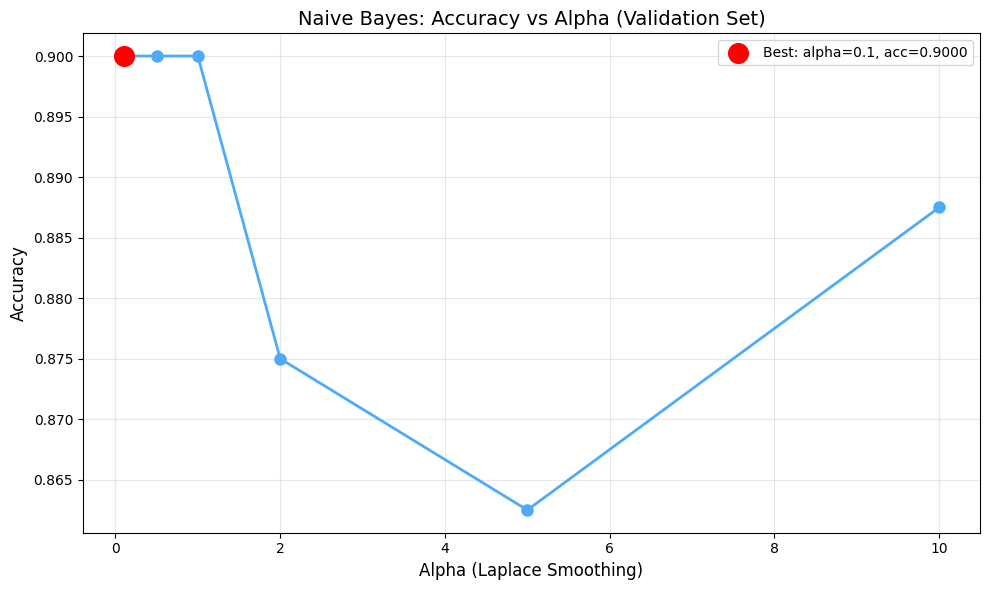


Best alpha: 0.1 (Validation Accuracy: 0.9000)
Naive Bayes trained! Test Accuracy: 0.9000


In [151]:
print("\n" + "="*50)
print("TRAINING NAIVE BAYES")
print("="*50)
# Train Naive Bayes
print("Hyperparameter Tuning: Alpha Values")

# Coba berbagai nilai alpha
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
alpha_accuracies = []

for alpha in alphas:
    nb_temp = MultinomialNB(alpha=alpha)
    nb_temp.fit(X_train, y_train)
    y_pred_val = nb_temp.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    alpha_accuracies.append(acc)
    print(f"   alpha={alpha:4.1f} → Val Accuracy: {acc:.4f}")

# Visualisasi
plt.figure(figsize=(10, 6))
plt.plot(alphas, alpha_accuracies, marker='o', linewidth=2, markersize=8, color='#4dabf7')
plt.xlabel('Alpha (Laplace Smoothing)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Naive Bayes: Accuracy vs Alpha (Validation Set)', fontsize=14)
plt.grid(True, alpha=0.3)

best_alpha_idx = np.argmax(alpha_accuracies)
best_alpha = alphas[best_alpha_idx]
best_acc_val = alpha_accuracies[best_alpha_idx]

plt.scatter(best_alpha, best_acc_val, color='red', s=200, 
            zorder=5, label=f'Best: alpha={best_alpha}, acc={best_acc_val:.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('visualisasi/naive_bayes_alpha_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest alpha: {best_alpha} (Validation Accuracy: {best_acc_val:.4f})")

# Train final model dengan alpha terbaik
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(X_train, y_train)

# Evaluate di test set
y_pred_nb_test = nb_model.predict(X_test)
nb_test_acc = accuracy_score(y_test, y_pred_nb_test)
print(f"Naive Bayes trained! Test Accuracy: {nb_test_acc:.4f}")

In [152]:
print("\n" + "="*50)
print("TRAINING k-NN")
print("="*50)

# Cari k optimal
from sklearn.metrics import accuracy_score

k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn_temp.fit(X_train, y_train)
    y_pred_val = knn_temp.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    accuracies.append(acc)
    print(f"   k={k:2d} → Val Accuracy: {acc:.4f}")


TRAINING k-NN
   k= 1 → Val Accuracy: 0.8625
   k= 2 → Val Accuracy: 0.8000
   k= 3 → Val Accuracy: 0.8875
   k= 4 → Val Accuracy: 0.8750
   k= 5 → Val Accuracy: 0.9125
   k= 6 → Val Accuracy: 0.9125
   k= 7 → Val Accuracy: 0.9125
   k= 8 → Val Accuracy: 0.8750
   k= 9 → Val Accuracy: 0.9000
   k=10 → Val Accuracy: 0.8625
   k=11 → Val Accuracy: 0.8750
   k=12 → Val Accuracy: 0.8750
   k=13 → Val Accuracy: 0.8875
   k=14 → Val Accuracy: 0.8625
   k=15 → Val Accuracy: 0.9000
   k=16 → Val Accuracy: 0.8500
   k=17 → Val Accuracy: 0.8625
   k=18 → Val Accuracy: 0.8500
   k=19 → Val Accuracy: 0.8625
   k=20 → Val Accuracy: 0.8625


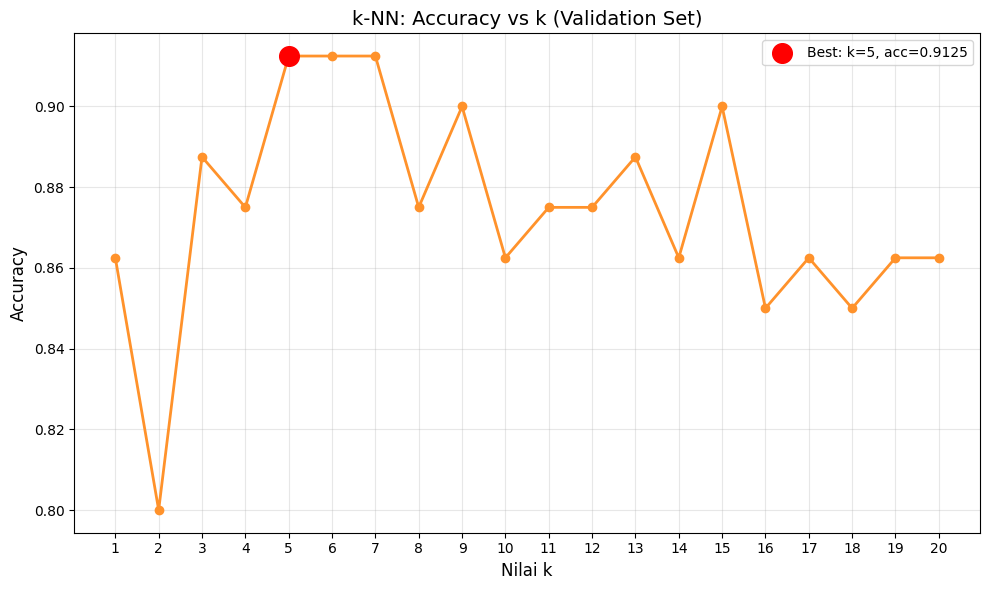


Best k: 5 (Validation Accuracy: 0.9125)
k-NN trained! Test Accuracy: 0.8625


In [153]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linewidth=2, color='#ff922b')
plt.xlabel('Nilai k', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('k-NN: Accuracy vs k (Validation Set)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

best_k_idx = np.argmax(accuracies)
best_k = k_values[best_k_idx]
best_knn_acc_val = accuracies[best_k_idx]

plt.scatter(best_k, best_knn_acc_val, color='red', s=200,
            zorder=5, label=f'Best: k={best_k}, acc={best_knn_acc_val:.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('visualisasi/knn_accuracy_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest k: {best_k} (Validation Accuracy: {best_knn_acc_val:.4f})")

# Train final model
knn_model = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
knn_model.fit(X_train, y_train)

# Evaluate di test set
y_pred_knn_test = knn_model.predict(X_test)
knn_test_acc = accuracy_score(y_test, y_pred_knn_test)
print(f"k-NN trained! Test Accuracy: {knn_test_acc:.4f}")


TRAINING DECISION TREE
   depth= 1 → Val Accuracy: 0.5500
   depth= 2 → Val Accuracy: 0.6750
   depth= 3 → Val Accuracy: 0.7125
   depth= 4 → Val Accuracy: 0.7125
   depth= 5 → Val Accuracy: 0.7375
   depth= 6 → Val Accuracy: 0.7125
   depth= 7 → Val Accuracy: 0.7250
   depth= 8 → Val Accuracy: 0.7625
   depth= 9 → Val Accuracy: 0.7500
   depth=10 → Val Accuracy: 0.7375
   depth=11 → Val Accuracy: 0.7375
   depth=12 → Val Accuracy: 0.7375
   depth=13 → Val Accuracy: 0.7250
   depth=14 → Val Accuracy: 0.7375
   depth=15 → Val Accuracy: 0.7375


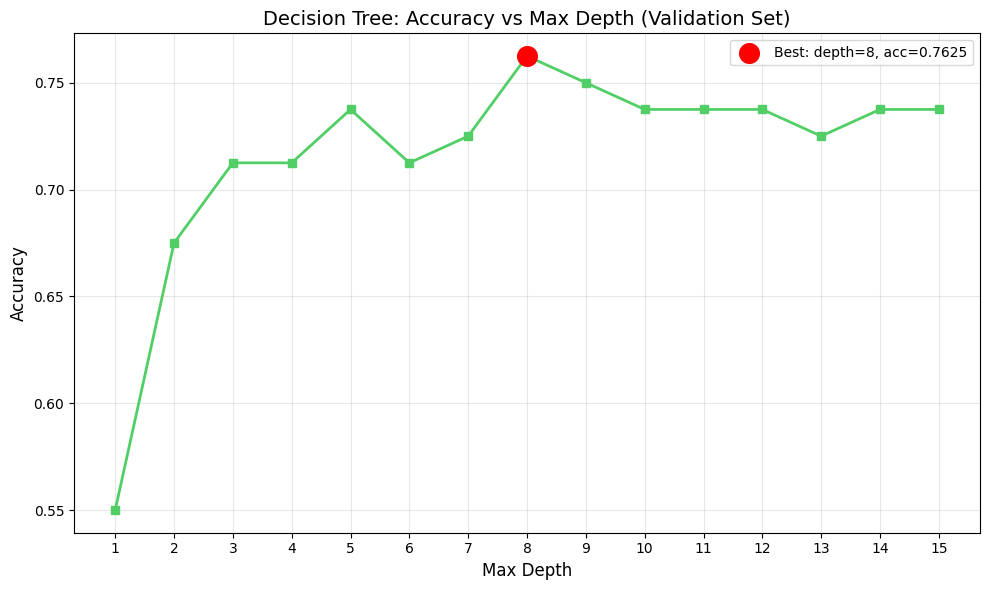


Best depth: 8 (Validation Accuracy: 0.7625)
Decision Tree trained! Test Accuracy: 0.7375


In [154]:
print("\n" + "="*50)
print("TRAINING DECISION TREE")
print("="*50)
# Cari depth optimal
depths = range(1, 16)
dt_accuracies = []

for depth in depths:
    dt_temp = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    dt_temp.fit(X_train, y_train)
    y_pred_val = dt_temp.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    dt_accuracies.append(acc)
    print(f"   depth={depth:2d} → Val Accuracy: {acc:.4f}")
    
# Plot akurasi vs depth
plt.figure(figsize=(10, 6))
plt.plot(depths, dt_accuracies, marker='s', linewidth=2, color='#51cf66')
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree: Accuracy vs Max Depth (Validation Set)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(depths)

best_depth_idx = np.argmax(dt_accuracies)
best_depth = depths[best_depth_idx]
best_dt_acc_val = dt_accuracies[best_depth_idx]

plt.scatter(best_depth, best_dt_acc_val, color='red', s=200,
            zorder=5, label=f'Best: depth={best_depth}, acc={best_dt_acc_val:.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('visualisasi/dt_accuracy_vs_depth.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest depth: {best_depth} (Validation Accuracy: {best_dt_acc_val:.4f})")

# Train final model dengan depth optimal
dt_model = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
dt_model.fit(X_train, y_train)

# Evaluate di test set
y_pred_dt_test = dt_model.predict(X_test)
dt_test_acc = accuracy_score(y_test, y_pred_dt_test)
print(f"Decision Tree trained! Test Accuracy: {dt_test_acc:.4f}")

In [155]:
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE ON TEST SET")
print("="*50)

from sklearn.metrics import classification_report

models = {
    'Naive Bayes': (nb_model, y_pred_nb_test),
    'k-NN': (knn_model, y_pred_knn_test),
    'Decision Tree': (dt_model, y_pred_dt_test)
}

print(f"{'Model':15} {'Test Accuracy':15}")
print("-" * 30)
for name, (model, y_pred) in models.items():
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:15} {acc:.4f}")

print("\n" + "="*50)
print("DETAILED REPORTS")
print("="*50)

for name, (model, y_pred) in models.items():
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


FINAL MODEL PERFORMANCE ON TEST SET
Model           Test Accuracy  
------------------------------
Naive Bayes     0.9000
k-NN            0.8625
Decision Tree   0.7375

DETAILED REPORTS

Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90        40
    Positive       0.90      0.90      0.90        40

    accuracy                           0.90        80
   macro avg       0.90      0.90      0.90        80
weighted avg       0.90      0.90      0.90        80


k-NN:
              precision    recall  f1-score   support

    Negative       0.82      0.93      0.87        40
    Positive       0.91      0.80      0.85        40

    accuracy                           0.86        80
   macro avg       0.87      0.86      0.86        80
weighted avg       0.87      0.86      0.86        80


Decision Tree:
              precision    recall  f1-score   support

    Negative       0.85      0.57      0.69        40
    Positive 

In [156]:
print("\n" + "="*50)
print("SAVING MODELS")
print("="*50)

models_to_save = {
    'naive_bayes': nb_model,
    'knn': knn_model,
    'decision_tree': dt_model
}

for name, model in models_to_save.items():
    filename = f'models/model_{name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"{filename} saved")

with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("models/vectorizer.pkl saved")



SAVING MODELS
models/model_naive_bayes.pkl saved
models/model_knn.pkl saved
models/model_decision_tree.pkl saved
models/vectorizer.pkl saved


In [157]:
# SLANG DICTIONARY KHUSUS KOMENTAR INSTAGRAM INDONESIA
SLANG_DICT = {
    # Kata gaul umum
    'yg': 'yang',
    'dg': 'dengan',
    'tdk': 'tidak',
    'gak': 'tidak',
    'ga': 'tidak',
    'nggak': 'tidak',
    'gk': 'tidak',
    'g': 'tidak',
    'jgn': 'jangan',
    'jg': 'juga',
    'sdh': 'sudah',
    'udh': 'sudah',
    'udah': 'sudah',
    'blm': 'belum',
    'belom': 'belum',
    'dlm': 'dalam',
    'dgn': 'dengan',
    'sbg': 'sebagai',
    'tsb': 'tersebut',
    'tpi': 'tapi',
    'tp': 'tapi',
    'krn': 'karena',
    'karna': 'karena',
    'klo': 'kalau',
    'kl': 'kalau',
    'kalo': 'kalau',
    'kyk': 'kayak',
    'kyknya': 'kayaknya',
    'ato': 'atau',
    'utk': 'untuk',
    'buat': 'untuk',
    'pd': 'pada',
    'org': 'orang',
    'org2': 'orang-orang',
    'mrk': 'mereka',
    'kmu': 'kamu',
    'km': 'kamu',
    'loe': 'kamu',
    'lu': 'kamu',
    'gw': 'saya',
    'gue': 'saya',
    'aku': 'saya',
    'ane': 'saya',
    'sy': 'saya',
    'sya': 'saya',
    'aneh': 'saya',
    'dpt': 'dapat',
    'dapet': 'dapat',
    'bs': 'bisa',
    'bisa2': 'bisa-bisa',
    'bgt': 'banget',
    'bngt': 'banget',
    'skrg': 'sekarang',
    'skrng': 'sekarang',
    'skr': 'sekarang',
    'lg': 'lagi',
    'lgi': 'lagi',
    'lgian': 'lagian',
    'sm': 'sama',
    'sma': 'sama',
    'ama': 'sama',
    'd': 'di',
    'dr': 'dari',
    'dri': 'dari',
    'trus': 'terus',
    'trs': 'terus',
    'trz': 'terus',
    'dkk': 'dan kawan-kawan',
    'dll': 'dan lain-lain',
    'dsb': 'dan sebagainya',
    'aja': 'saja',
    'aj': 'saja',
    'doang': 'saja',
    'dong': 'dongs',
    'sih': 'sih',
    'deh': 'deh',
    'nih': 'ini',
    'tu': 'itu',
    'tuh': 'itu',
    'mah': 'mah',
    'kok': 'kok',
    'loh': 'loh',
    'yah': 'ya',
    'yaa': 'ya',
    'yuk': 'ayo',
    'yukk': 'ayo',
    'bkn': 'bukan',
    'bukan2': 'bukan-bukan',
    'knp': 'kenapa',
    'knapa': 'kenapa',
    'gmn': 'gimana',
    'gimana2': 'gimana-gimana',
    'gt': 'gitu',
    'gtu': 'gitu',
    'gitu2': 'gitu-gitu',
    'jd': 'jadi',
    'jdi': 'jadi',
    'pdhl': 'padahal',
    'smoga': 'semoga',
    'smga': 'semoga',
    'tll': 'terlalu',
    'tllu': 'terlalu',
    'trlalu': 'terlalu',
    'kmrn': 'kemarin',
    'kmren': 'kemarin',
    'brp': 'berapa',
    'brpa': 'berapa',
    'lbh': 'lebih',
    'lbih': 'lebih',
    'cpt': 'cepat',
    'cepat2': 'cepat-cepat',
    'plg': 'paling',
    'plng': 'paling',
    'sll': 'selalu',
    'slalu': 'selalu',
    'mksd': 'maksud',
    'mksud': 'maksud',
    'mksh': 'makasih',
    'trmksh': 'terima kasih',
    'thx': 'terima kasih',
    'ty': 'terima kasih',
    'makasi': 'terima kasih',
    'makasih': 'terima kasih',
    'ok': 'oke',
    'okey': 'oke',
    'okeee': 'oke',
    
    # Kata kasar/umpatan (dari data)
    'tolol': 'bodoh',
    'geblek': 'bodoh',
    'bego': 'bodoh',
    'bejat': 'jahat',
    'goblok': 'bodoh',
    'idiot': 'bodoh',
    'dungu': 'bodoh',
    'bencong': 'banci',
    'anjing': 'anjing',
    'babi': 'babi',
    'bangsat': 'bangsat',
    'bajingan': 'bajingan',
    'lonte': 'pelacur',
    'pelacur': 'pelacur',
    'jablay': 'jalang',
    'jalang': 'jalang',
    'pepek': 'vagina',
    'kontol': 'penis',
    'memek': 'vagina',
    'ngentot': 'bersetubuh',
    'jancok': 'sialan',
    'jancuk': 'sialan',
    'asu': 'anjing',
    'bangsat': 'sialan',
    'kampret': 'sialan',
    'brengsek': 'sialan',
    'jembut': 'rambut kemaluan',
    'kirik': 'anjing kecil',
    'kampungan': 'norak',
    'norak': 'kampungan',
    'keji': 'jahat',
    'laknat': 'terkutuk',
    'setan': 'iblis',
    
    # Kata khusus dari data komentar
    'pelakor': 'perebut laki orang',
    'pecun': 'perempuan curang',
    'japok': 'janda penggoda',
    'janda': 'janda',
    'gatel': 'gatal',
    'gundik': 'selir',
    'valakor': 'perebut laki orang',
    'cun': 'cantik',
    'pecun': 'perempuan curang',
    'muljem': 'mulan jameela',
    'lonte': 'pelacur',
    'jablay': 'jalang',
    'brengsek': 'sialan',
    'bacot': 'banyak bicara',
    'bacod': 'banyak bicara',
    'bacok': 'banyak bicara',
    'bacut': 'banyak bicara',
    'bacul': 'pengecut',
    'bacotan': 'omongan',
    'bacotannya': 'omongannya',
    
    # Kata gaul artis/selebritis
    'ertong': 'artis',
    'hartis': 'artis',
    'celebgram': 'selebriti instagram',
    'selebgram': 'selebriti instagram',
    'netijen': 'netizen',
    'nitezer': 'netizen',
    'balajaer': 'pembela artis',
    'balaaer': 'pembela artis',
    'baer': 'pembela artis',
    'bajer': 'pembela artis',
    'mujaer': 'pemuja artis',
    'jaer': 'pembela artis',
    'folowers': 'followers',
    'folower': 'follower',
    'folow': 'follow',
    'folo': 'follow',
    
    # Singkatan nama artis (dari data)
    'att': 'ayutingting',
    'nagita': 'nagita',
    'rafi': 'raffi',
    'gigi': 'gigi',
    'via': 'via vallen',
    'ayu': 'ayu tingting',
    'mulan': 'mulan jameela',
    'jedun': 'jessica iskandar',
    'mamad': 'raffi ahmad',
    'mimi': 'mimi peri',
    'raisa': 'raisa',
    'agnes': 'agnes monica',
    'ishana': 'ishana',
    'niki': 'nikita',
    'kdr': 'kadir',
    'kador': 'kadir',
    'bunda': 'ibu',
    'mba': 'mbak',
    'mb': 'mbak',
    'kak': 'kakak',
    'dek': 'adik',
    'dedek': 'adik',
    'emak': 'ibu',
    'bapak': 'ayah',
    'papa': 'ayah',
    'mama': 'ibu',
    'ibu2': 'ibu-ibu',
    'emak2': 'ibu-ibu',
    
    # Kata bahasa campuran
    'kids': 'anak',
    'jaman': 'zaman',
    'now': 'sekarang',
    'time': 'waktu',
    'love': 'cinta',
    'happy': 'bahagia',
    'sad': 'sedih',
    'mood': 'suasana hati',
    'story': 'cerita',
    'status': 'status',
    'posting': 'posting',
    'upload': 'unggah',
    'caption': 'keterangan',
    'comment': 'komentar',
    'share': 'bagikan',
    'like': 'suka',
    'unlike': 'tidak suka',
    'tag': 'tandai',
    'mention': 'sebut',
    'fyp': 'for you page',
    'dm': 'pesan langsung',
    'pm': 'pesan pribadi',
    'btw': 'by the way',
    'omg': 'oh my god',
    'lol': 'laugh out loud',
    'wkwk': 'wkwk',
    'wkwkwk': 'wkwk',
    'haha': 'haha',
    'hahaha': 'haha',
    'hehe': 'hehe',
    'hihi': 'hihi',
    
    # Kata repetitif (dari data)
    'anjir': 'anjing',
    'anjirr': 'anjing',
    'anjirrr': 'anjing',
    'anyiennnnggg': 'anying',
    'hadeww': 'aduh',
    'hadewww': 'aduh',
    'hadewwww': 'aduh',
    'weeewww': 'wow',
    'wowww': 'wow',
    'yessss': 'ya',
    'noooo': 'tidak',
    'duhhh': 'aduh',
    'duhh': 'aduh',
    'ihhh': 'ih',
    'asliii': 'asli',
    'banggeett': 'banget',
    'bangettt': 'banget',
    'kerennnn': 'keren',
    'kerenn': 'keren',
    'cantikk': 'cantik',
    'cantikkk': 'cantik',
    'gantenggg': 'ganteng',
    'gantengg': 'ganteng',
    'lucuu': 'lucu',
    'lucuuu': 'lucu',
    'baikk': 'baik',
    'baikss': 'baik',
    'jelekk': 'jelek',
    'jelekkk': 'jelek',
    'norakk': 'norak',
    'norakkk': 'norak',
    
    # Typo umum
    'emang': 'memang',
    'emng': 'memang',
    'bner': 'benar',
    'bener': 'benar',
    'pake': 'pakai',
    'pke': 'pakai',
    'bikin': 'buat',
    'bkin': 'buat',
    'ngmg': 'ngomong',
    'ngmng': 'ngomong',
    'ngomong': 'bicara',
    'bicara': 'berkata',
    'bilang': 'katakan',
    'kaya': 'kayak',
    'kek': 'kayak',
    'kayanya': 'kayaknya',
    'kayax': 'kayaknya',
    'kayakny': 'kayaknya',
    'kliatan': 'kelihatan',
    'keliatan': 'kelihatan',
    'kliatan': 'kelihatan',
    'keliatannya': 'kelihatannya',
    'ngaco': 'ngawur',
    'ngawur': 'sembarangan',
    'sembrono': 'ceroboh',
    'ceroboh': 'tidak hati-hati',
    
    # Kata dari komentar spesifik
    'pencitraan': 'pencitraan',
    'gimmick': 'rekayasa',
    'settingan': 'rekayasa',
    'kabur': 'lari',
    'kaburin': 'lari dari',
    'kaburkan': 'lari kan',
    'diem': 'diam',
    'diemin': 'diamkan',
    'diemvang': 'diam saja',
    'mingkem': 'diam',
    'bacot': 'banyak bicara',
    'bacotan': 'omongan',
    'nyinyir': 'mencela',
    'nyinyirin': 'mencela',
    'nyinyiran': 'celaan',
    'sok': 'pura-pura',
    'sokan': 'pura-pura',
    'alay': 'kekanakan',
    'lebay': 'berlebihan',
    'lebayan': 'berlebihan',
    'norak': 'kampungan',
    'norakan': 'kampungan',
    'kampungan': 'norak',
    'jaim': 'jaga image',
    'jaimin': 'jaga image',
    'caper': 'cari perhatian',
    'caperan': 'cari perhatian',
    'alay': 'kekanakan',
    'alayan': 'kekanakan',
    
    # Kata positif
    'keren': 'hebat',
    'mantap': 'bagus',
    'mantul': 'mantap betul',
    'cakep': 'bagus',
    'kece': 'keren',
    'gemesh': 'gemas',
    'gemes': 'gemas',
    'gemesin': 'menggemaskan',
    'gemoy': 'imut',
    'imut': 'lucu',
    'lucu': 'menggemaskan',
    'gemes': 'gemas',
    'baper': 'bawa perasaan',
    'baperan': 'bawa perasaan',
    'baperin': 'bawa perasaan',
    'bucin': 'budak cinta',
    'bucinan': 'budak cinta',
    
    # Tambahan dari pola komentar
    'woles': 'santai',
    'santuy': 'santai',
    'santai': 'tenang',
    'galau': 'sedih',
    'galauin': 'menyedihkan',
    'galauan': 'kesedihan',
    'gabut': 'gak ada kerjaan',
    'gabutan': 'tidak ada kerjaan',
    'mager': 'malas gerak',
    'mageran': 'malas gerak',
    'malming': 'malam minggu',
    'jemput': 'jemput',
    'jemputan': 'penjemputan',
    'jomblo': 'single',
    'jombloan': 'masa single',
    'jomblones': 'jomblo kronis',
    
    # Kata ending -in (informal)
    'liat': 'lihat',
    'liatin': 'lihat',
    'ngerti': 'mengerti',
    'ngertiin': 'mengerti',
    'tanggung': 'tanggung',
    'tanggungin': 'menanggung',
    'tanggungjawab': 'tanggung jawab',
    'tanggungjawabin': 'menanggung jawab',
    'perhatiin': 'perhatikan',
    'perhatian': 'perhatian',
    'denger': 'dengar',
    'dengerin': 'dengarkan',
    'nunggu': 'tunggu',
    'nungguin': 'menunggu',
    'nungguinnya': 'menunggunya',
    'nungguinnye': 'menunggunya',
    'nungguinye': 'menunggunya',
    'bantuin': 'bantu',
    'bantuan': 'bantuan',
    'tolongin': 'tolong',
    'tolongan': 'pertolongan',
    'jemputin': 'jemput',
    'jemputan': 'penjemputan',
}

In [158]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

In [159]:
preprocessing_tools = {
    'slang_dict': SLANG_DICT,
    'stemmer': stemmer,
    'stopword_remover': stopword_remover
}

In [160]:
with open('models/preprocessing_tools.pkl', 'wb') as f:
    pickle.dump(preprocessing_tools, f)
print("models/preprocessing_tools.pkl saved")

models/preprocessing_tools.pkl saved
